In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib import ticker, cm

In [2]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2201/3992394973.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  MetaD = plumed.read_as_pandas("data/metad_data.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2201/3992394973.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")


Text(0, 0.5, 'Probability density')

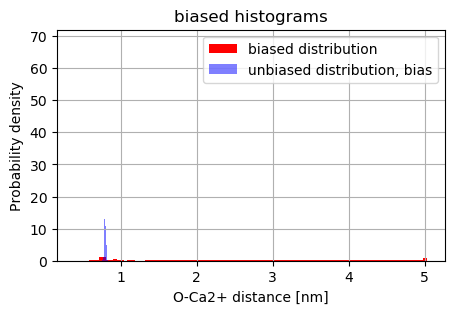

In [3]:
MetaD = plumed.read_as_pandas("data/metad_data.dat")
Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")
plt.rcParams["figure.figsize"] = (5, 3)

MetaD_eq = MetaD.iloc[600000:]
Funnel_eq = Funnel.iloc[600000:]
merged_data = pd.merge(Funnel_eq, MetaD_eq, on="time")
selected_columns = merged_data[['fps.lp', 'metad.rbias']]

val_bias, bins_bias, patches_bias = plt.hist(selected_columns["fps.lp"], bins=100, density=True, color='r', label="biased distribution")
kT = 1

w = [math.exp(selected_columns["metad.rbias"][i]/kT) for i in range(len(selected_columns["fps.lp"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(selected_columns["fps.lp"], bins=500, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution, bias")
plt.grid()
plt.legend(loc="best")
plt.title("biased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")
plt.ylim([0, 20])

# Posso riportare anche questo plot, magari facendo uno zoom!

Text(0, 0.5, 'Free energy [kcal/mol]')

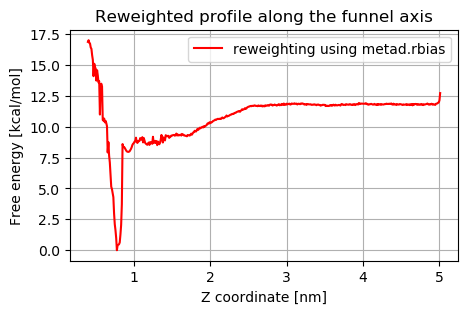

In [5]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)
plt.rcParams["figure.figsize"] = (5, 3)

plt.plot(dist, F/4.184, 'r',label="reweighting using metad.rbias")

with open('fes_fps.dat', 'w') as file:
    for item1, item2 in zip(dist, F):
        file.write(f"{item1}\t{item2/4.184}\n")  # Using tab as a separator

plt.grid()
plt.legend(loc="best")
plt.title("Reweighted profile along the funnel axis")
plt.xlabel("Z coordinate [nm]")
plt.ylabel("Free energy [kcal/mol]")

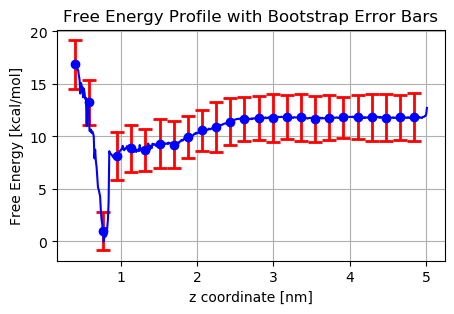

In [23]:
# Generate Bootstrap Samples
# Assuming you have n data points (distances and corresponding free energies), 
# you can create N bootstrap samples

# Number of bootstrap samples
N = 500

# Function to generate bootstrap samples
def generate_bootstrap_samples(data, N):
    n = len(data)
    bootstrap_samples = np.random.choice(data, (N, n), replace=True)
    return bootstrap_samples

bootstrap_samples = generate_bootstrap_samples(F/4.184, N)

# Calculate the standard deviation of the bootstrap samples
errors = np.std(bootstrap_samples, axis=0)

# Combine distance points, free energies, and errors for better visualization
free_energy_with_errors = list(zip(dist, F/4.184, errors))

step = 20
plt.rcParams["figure.figsize"] = (5, 3)
plt.errorbar(dist[::step], F[::step]/4.184, yerr=errors[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)
plt.plot(dist, F/4.184, 'b')
plt.title('Free Energy Profile with Bootstrap Error Bars')
plt.xlabel('z coordinate [nm]')
plt.ylabel('Free Energy [kcal/mol]')
plt.grid(True)
plt.show()

# Block standard error

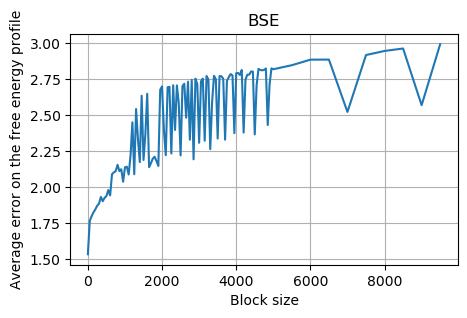

In [38]:
# Here I use a script validated by Bonomi:
# the script do_block_fes.py divides the space of the CV in many bins.
# Each bins contains data, i.e., many couples (Ox_rho, exp(metad.rbias)). You have selected 400000 points (last 400 ns)
# The data in each bin are divided in 10, 50, 100, etc parts and an error is returned

errblocks = np.loadtxt("blocks/err.blocks")

nblocks = [errblocks[i][0] for i in range(0, len(errblocks))]
err = [errblocks[i][1] for i in range(0, len(errblocks))]

plt.plot(nblocks, err)
plt.title('BSE')
plt.xlabel('Block size')
plt.ylabel('Average error on the free energy profile')
plt.grid(True)
plt.show()


In [37]:
len(nblocks)

110